In [1]:
from numpy import *
import MDAnalysis as mda
import MDAnalysis.analysis.distances
from pylab import *
style.use('seaborn-poster')
import glob
import scipy.stats

In [2]:
EQPOINT=250


h2opath="data/water/solvent_included/"
pegpath="data/peg/solvent_included/"

#glob tprs
h2ogros=glob.glob(h2opath+"*.gro")
peggros=glob.glob(pegpath+"*.gro")

#glob tprs
h2otprs=glob.glob(h2opath+"*.tpr")
pegtprs=glob.glob(pegpath+"*.tpr")

#trjs
h2otrjs=glob.glob(h2opath+"*.xtc")
pegtrjs=glob.glob(pegpath+"*.xtc")

systemtprs=[h2otprs,pegtprs]
systemtrjs=[h2otrjs,pegtrjs]



resids_proper=list(arange(-4,67))+list(arange(69,238))
resids=list(arange(-4,67))+[nan,nan]+list(arange(69,238))#get universes 
h2ou=[]
pegu=[]

for i in range(len(h2ogros)):
    h2ou.append(mda.Universe(h2otprs[i],h2otrjs[i]))
    #fix resids immediately
    h2ou[i].select_atoms("protein or resname CH6").residues.resids = resids_proper
for i in range(len(peggros)):
    pegu.append(mda.Universe(pegtprs[i],pegtrjs[i]))
    #fix resids immediately
    pegu[i].select_atoms("protein or resname CH6").residues.resids = resids_proper
    
    
#compile all the systems in one list
systems = [h2ou,pegu]
system_names = ['No-PEG','PEG']
#[]
#[tol-darkgreen,tol-darkblue,tol-bottompurple]
twoColour=["#0A732D","#332288"]
# Dark green,    
#sixColor=['#0A732D','#332288','#88CCEE',"#44AA99",'#882255','#D250BC']
#colorScheme=sixColor
colourScheme = twoColour
# Let's set up the selections for each trajectory by chain

# i want to make a list that has the sh2 domains selected in each sublist so that each one has 6 selections.
h2ou_fullprotein=[]
pegu_fullprotein=[]

h2ou_fullprotein_string=[]
pegu_fullprotein_string=[]


h2ou_notail=[]
pegu_notail=[]


h2ou_notail_string=[]
pegu_notail_string=[]


for i in range(len(h2otrjs)):
    h2ou_notail.append(h2ou[i].select_atoms("(protein or resname CH6) and resid 1:228"))
    h2ou_notail_string.append("(protein or resname CH6) and resid 1:228")
    h2ou_fullprotein.append(h2ou[i].select_atoms("(protein or resname CH6)"))
    h2ou_fullprotein_string.append("(protein or resname CH6)")
    
for i in range(len(pegtrjs)):
    pegu_notail.append(pegu[i].select_atoms("(protein or resname CH6) and resid 1:228"))
    pegu_notail_string.append("(protein or resname CH6) and resid 1:228")
    pegu_fullprotein.append(pegu[i].select_atoms("(protein or resname CH6)"))
    pegu_fullprotein_string.append("(protein or resname CH6)")

fullprotein_selections=[h2ou_fullprotein,pegu_fullprotein]
fullprotein_selections_string=[h2ou_fullprotein_string,pegu_fullprotein_string]
notail_selections = [h2ou_notail,pegu_notail]
notail_selections_string = [h2ou_notail_string,pegu_notail_string]




    

In [3]:
# Next lets count the atoms


all_total_residue_atom_counts=[]
for i in range(len(systems)):
    sub=[]
    for j in range(len(systems[i])):
        u = systems[i][j]
        
        rescounts=[]
        for t in range(EQPOINT,len(u.trajectory)):
            u.trajectory[t]
            contacts1=u.select_atoms("protein and around 3.5 resname CH6",updating=True)

        
            for n in range(len(contacts1.resids)):
                
                rescounts.append(contacts1.resids[n])
        
            #rescounts+=list(contacts1.resids)
        sub.append(rescounts)
    all_total_residue_atom_counts.append(sub)
        

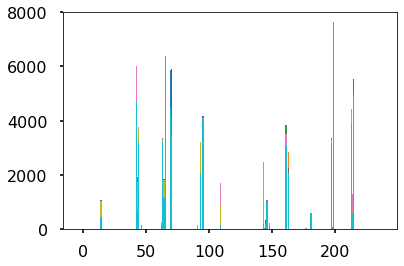

In [5]:
all_total_residue_atom_counts_hists=[]
for i in range(len(all_total_residue_atom_counts)):
    sub = []
    for j in range(len(all_total_residue_atom_counts[i])):
        
        a=hist(all_total_residue_atom_counts[i][j],bins = arange(-4.5,238.5,1))
        
        sub.append(a[0]/(len(systems[i][j].trajectory)-EQPOINT))
    all_total_residue_atom_counts_hists.append(sub)
    
    
system_avg_hist_y = []
system_sem_hist_y = []

for i in range(len(all_total_residue_atom_counts_hists)):
    system_avg_hist_y.append(mean(all_total_residue_atom_counts_hists[i],axis = 0))
    system_sem_hist_y.append(scipy.stats.sem(all_total_residue_atom_counts_hists[i],axis = 0))

(-1.5, 1.5)

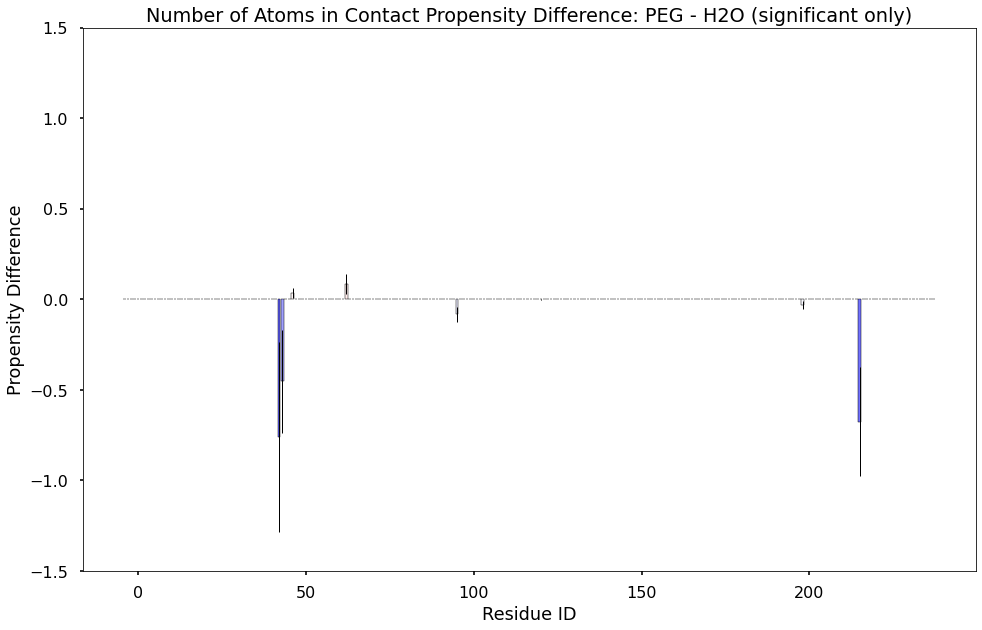

In [6]:
avgDiffBars = (system_avg_hist_y[1] - system_avg_hist_y[0])
semDiffBars = sqrt(system_sem_hist_y[1]**2 + system_sem_hist_y[0]**2)
colors =[]

for i in range(len(avgDiffBars)):
    if avgDiffBars[i] > 0:
        colors.append([1.,1-(avgDiffBars[i]/max(abs(avgDiffBars))),1-(avgDiffBars[i]/max(abs(avgDiffBars)))])
    if avgDiffBars[i] <=0:
        colors.append([1-(-avgDiffBars[i]/max(abs(avgDiffBars))),1-(-avgDiffBars[i]/max(abs(avgDiffBars))),1.])
        
# get significant only
avgSignifBars=copy(avgDiffBars)
semSignifBars=copy(semDiffBars)
for i in range(len(avgDiffBars)):
    
    if abs(semDiffBars[i]) > abs(avgDiffBars[i]):
        avgSignifBars[i] = 0
        semSignifBars[i] = 0        
        
       
        

        
figure(figsize = (16,10))

bar(arange(-4.5,238.5,1)[:-1]+.5,avgSignifBars,color = colors,edgecolor= 'black')
errorbar(arange(-4.5,238.5,1)[:-1]+.5,avgSignifBars,semSignifBars,fmt=".",markersize = 0.01,linewidth = 1, color = "black")
xlabel("Residue ID")
ylabel("Propensity Difference")
title("Number of Atoms in Contact Propensity Difference: PEG - H2O (significant only)") 
ylim(-1.5,1.5)

In [7]:
sum(avgSignifBars)

-1.8806924101198406

In [8]:
save("nAtomsInContactWithCH6byResidue_SignificantDifferenceBars.npy",avgSignifBars)
save("nAtomsInContactWithCH6byResidue_SignificantDifferenceSEMs.npy",semSignifBars)

In [11]:
p=systems[0][0].select_atoms("protein or resname CH6")
for i in range(len(p.residues)):
    print(p.residues.resids[i],p.residues.resnames[i])

-4 MET
-3 VAL
-2 SER
-1 LYS
0 GLY
1 GLU
2 GLU
3 ASP
4 ASN
5 MET
6 ALA
7 ILE
8 ILE
9 LYS
10 GLU
11 PHE
12 MET
13 ARG
14 PHE
15 LYS
16 VAL
17 HSD
18 MET
19 GLU
20 GLY
21 SER
22 VAL
23 ASN
24 GLY
25 HSD
26 GLU
27 PHE
28 GLU
29 ILE
30 GLU
31 GLY
32 GLU
33 GLY
34 GLU
35 GLY
36 ARG
37 PRO
38 TYR
39 GLU
40 GLY
41 THR
42 GLN
43 THR
44 ALA
45 LYS
46 LEU
47 LYS
48 VAL
49 THR
50 LYS
51 GLY
52 GLY
53 PRO
54 LEU
55 PRO
56 PHE
57 ALA
58 TRP
59 ASP
60 ILE
61 LEU
62 SER
63 PRO
64 GLN
65 PHE
66 CH6
69 SER
70 LYS
71 ALA
72 TYR
73 VAL
74 LYS
75 HSD
76 PRO
77 ALA
78 ASP
79 ILE
80 PRO
81 ASP
82 TYR
83 LEU
84 LYS
85 LEU
86 SER
87 PHE
88 PRO
89 GLU
90 GLY
91 PHE
92 LYS
93 TRP
94 GLU
95 ARG
96 VAL
97 MET
98 ASN
99 PHE
100 GLU
101 ASP
102 GLY
103 GLY
104 VAL
105 VAL
106 THR
107 VAL
108 THR
109 GLN
110 ASP
111 SER
112 SER
113 LEU
114 GLN
115 ASP
116 GLY
117 GLU
118 PHE
119 ILE
120 TYR
121 LYS
122 VAL
123 LYS
124 LEU
125 ARG
126 GLY
127 THR
128 ASN
129 PHE
130 PRO
131 SER
132 ASP
133 GLY
134 PRO
135 VAL
136 MET
